# Correlations 5S
fistly define the UUID of the experiment to use

In [1]:
experimentId="09aa67d8-c865-4a95-a7c5-de7b6adadbce"

-------------------------------------------------------

In [2]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.stats as sst
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import sklearn.metrics as skm

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load cognition

In [3]:
samplerate=200  #Should rethink this

In [4]:
annotations, signalsMetadata = loadCOGNITIONSpindles(cognipath)

In [5]:
annotations.head()

,subjectId,channel,startTime,stopTime,duration,phase,labelerId,type,samplerate,startInd,stopInd
0,0001,C3,1938.132297,1939.202326,1.070029,2,0001,spindle,200,387626,387840
1,0001,C3,2047.217898,2048.112834,0.894936,2,0001,spindle,200,409444,409623
2,0001,C3,2170.856032,2171.634237,0.778205,3,0001,spindle,200,434171,434327
3,0001,C3,2219.766538,2220.894943,1.128405,3,0001,spindle,200,443953,444179
4,0001,C3,2263.482492,2264.357974,0.875482,3,0001,spindle,200,452696,452872


In [6]:
signalsMetadata.head()

,filename,channel,subjectId,duration,samplerate,isOriginalSamplerate,database
0,COG001_canal_C3.txt,C3-M2,0001,39600,200,False,COGNITION
1,COG002_canal_C3.txt,C3-M2,0002,39600,200,False,COGNITION
2,COG003_canal_C3.txt,C3-M2,0003,39600,200,False,COGNITION
3,COG004_canal_C3.txt,C3-M2,0004,39600,200,False,COGNITION
4,COG005_canal_C3.txt,C3-M2,0005,39600,200,False,COGNITION


## Load experiment results

In [7]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [8]:
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0004, 0005, 0006, 0007]","[0003, 0008]",0002,9e8c92c9-d012-4e46-a60f-74540df5103d,0.008075
1,0001,E1,[0001],"[0002, 0005, 0006, 0008]","[0007, 0004]",0003,16258fa7-20b7-495e-a32f-75aec610ef66,0.005000
2,0001,E1,[0001],"[0002, 0003, 0005, 0007]","[0006, 0008]",0004,3654a0cd-77b5-4bcf-8238-54296d7c1a27,0.012035
3,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0006, 0004]",0005,8cec6075-9679-4f7b-b5c7-d6ff36147e79,0.010340
4,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0004, 0005]",0006,5401bdbe-22c1-42a0-9740-d2921a271387,0.010340
5,0001,E1,[0001],"[0002, 0004, 0005, 0008]","[0003, 0006]",0007,2d237bf5-9265-439a-827b-f1411cb4fc3a,0.006673
6,0001,E1,[0001],"[0002, 0005, 0006, 0007]","[0003, 0004]",0008,8bf430c8-bbc9-4ee2-927e-75f7a5e76570,0.006822


In [9]:
#we show the difference in class inbalance for the annotation criteria considered
experimentModels[['criteriumName','spindleTimeRate']].groupby('criteriumName').describe()

spindleTimeRate                                                 \
                        count      mean       std    min       25%       50%   
criteriumName                                                                  
E1                        7.0  0.008469  0.002511  0.005  0.006748  0.008075   

                                  
                   75%       max  
criteriumName                     
E1             0.01034  0.012035

In [10]:
featureSelection

,window,characteristic,bandName,score
0,2,hjortActivity,beta2,69.0
1,1,hjortActivity,sigma,63.0
2,2,hjortActivity,beta1,42.0
3,2,hjortActivity,delta2,41.0
4,1.5,sigmaIndex,broadband,39.0
5,2,sigmaIndex,broadband,39.0
6,2,hjortActivity,theta,38.0
7,2,hjortMobility,beta1,37.0
8,2,hjortActivity,alpha,35.0
9,1,sigmaIndex,broadband,34.0


## Hyperparameter definition
this should come from a previous evaluation notebook

In [11]:
hyperClose=0.25
hyperDuration=0.3
hyperThres=0.4
hyperDepth=10

## Testing with E2 criterium
we test the optimal points for the prediction threshold and number of boost iterations in the different validation groups

In [12]:
experimentModels=experimentModels[experimentModels.criteriumName=='E1'].reset_index(drop=True)
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0004, 0005, 0006, 0007]","[0003, 0008]",0002,9e8c92c9-d012-4e46-a60f-74540df5103d,0.008075
1,0001,E1,[0001],"[0002, 0005, 0006, 0008]","[0007, 0004]",0003,16258fa7-20b7-495e-a32f-75aec610ef66,0.005000
2,0001,E1,[0001],"[0002, 0003, 0005, 0007]","[0006, 0008]",0004,3654a0cd-77b5-4bcf-8238-54296d7c1a27,0.012035
3,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0006, 0004]",0005,8cec6075-9679-4f7b-b5c7-d6ff36147e79,0.010340
4,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0004, 0005]",0006,5401bdbe-22c1-42a0-9740-d2921a271387,0.010340
5,0001,E1,[0001],"[0002, 0004, 0005, 0008]","[0003, 0006]",0007,2d237bf5-9265-439a-827b-f1411cb4fc3a,0.006673
6,0001,E1,[0001],"[0002, 0005, 0006, 0007]","[0003, 0004]",0008,8bf430c8-bbc9-4ee2-927e-75f7a5e76570,0.006822


In [13]:
#threshold for the metric by event
masterIoU=0.2

In [14]:
def getIou(coordA,coordB):
    if (coordA[1]<coordB[0])|(coordB[1]<coordA[0]): #NOT INTERSECTION
        iou=0
    else:   #INTERSECTION
        inter=np.min((coordA[1]-coordB[0],coordB[1]-coordA[0]))
        union=np.max((coordA[1]-coordB[0],coordB[1]-coordA[0]))
        iou=inter/union
    return iou

def annotationPairToMetrics(annotations,detections,thresIoU=0.2):
    #get the coords
    gtCoords=zip(annotations.startInd,annotations.stopInd)
    outCoords=zip(detections.startInd,detections.stopInd)
    #calculate the iou vector
    iouVector=np.array(list(itt.starmap(getIou,itt.product(gtCoords,outCoords))))
    #reshape to a matrix
    iouMatrix=iouVector.reshape(len(annotations),len(detections))
    #binarize
    binarized=iouMatrix>thresIoU
    #calculateF1
    outF1=(np.sum(np.max(binarized,axis=0))+np.sum(np.max(binarized,axis=1)))/(len(annotations)+len(detections))
    recall=np.sum(np.max(binarized,axis=1))/len(annotations)
    precision=np.sum(np.max(binarized,axis=0))/len(detections)
    return outF1,recall,precision

In [15]:
def getMetricTables(annotations,detections,thresIoU=0.2):
    #get the coords
    gtCoords=zip(annotations.startInd,annotations.stopInd)
    outCoords=zip(detections.startInd,detections.stopInd)
    #calculate the iou vector
    iouVector=np.array(list(itt.starmap(getIou,itt.product(gtCoords,outCoords))))
    #reshape to a matrix
    iouMatrix=iouVector.reshape(len(annotations),len(detections))
    #create tables
    index0=np.apply_along_axis(np.argmax,0,iouMatrix)
    iou0=np.apply_along_axis(np.max,0,iouMatrix)
    index1=np.apply_along_axis(np.argmax,1,iouMatrix)
    iou1=np.apply_along_axis(np.max,1,iouMatrix)
    
    tableOut=pd.DataFrame({
        'indexGT':index0,
        'iou':iou0
    })

    tableGT=pd.DataFrame({
        'indexOut':index1,
        'iou':iou1
    })

    tableOut['type']='out'
    tableGT['type']='gt'
    tableOut['indexOut']=tableOut.index
    tableGT['indexGT']=tableGT.index
    #Correct external indexes of objects not overlapping
    tableOut.loc[tableOut.iou==0,'indexGT']='NA'
    tableGT.loc[tableGT.iou==0,'indexOut']='NA'
    #set tps
    tableOut['tp']=tableOut.iou>thresIoU
    tableOut['fp']=tableOut.iou<=thresIoU
    tableGT['tp']=tableGT.iou>thresIoU
    tableGT['fn']=tableGT.iou<=thresIoU

    return tableOut,tableGT

In [16]:
allTablesOut=pd.DataFrame({})
allDetections=[]
allAnnotations=[]

for ind,row in experimentModels.iterrows():
    print('*************************')
    print(str(ind+1)+' of '+str(len(experimentModels)) )
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)

    testSubjectId=row.test
    #Define annotations criterium
    usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
    rawLabels=probabilities>=hyperThres
    
    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)
    
    #By-event tables
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    tableOut,tableGT=getMetricTables(gtAnnotations,processedAnnotations)
    
    #Process tables
    gtAnnotations['durationGT']=gtAnnotations['duration']
    tableOut=pd.merge(tableOut,gtAnnotations["durationGT"],"left",left_on="indexGT",right_index=True)
    processedAnnotations['durationOut']=processedAnnotations['duration']
    tableOut=pd.merge(tableOut,processedAnnotations["durationOut"],"left",left_on="indexOut",right_index=True)

    tableOut['subjectId']=row.test

    allTablesOut=pd.concat((allTablesOut,tableOut))
    allDetections.append(processedAnnotations)
    allAnnotations.append(gtAnnotations)


*************************
1 of 7
*************************
2 of 7
*************************
3 of 7
*************************
4 of 7
*************************
5 of 7
*************************
6 of 7
*************************
7 of 7


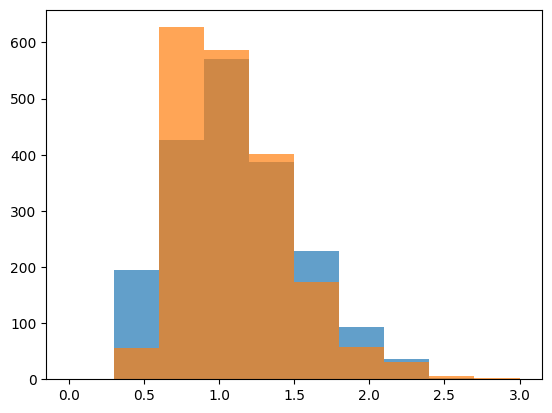

In [17]:
plt.hist(allTablesOut[allTablesOut.tp].durationOut,range=[0,3],alpha=0.7)
plt.hist(allTablesOut[allTablesOut.tp].durationGT,range=[0,3],alpha=0.7)
plt.show()

In [18]:
px.scatter(allTablesOut[allTablesOut.tp],x="durationGT",y="durationOut",trendline="lowess")

In [19]:
result=sst.linregress(allTablesOut[allTablesOut.tp].durationGT,allTablesOut[allTablesOut.tp].durationOut)

In [20]:
result

LinregressResult(slope=0.6943664440918698, intercept=0.35330313648406975, rvalue=0.6141905530186504, pvalue=1.1751376731423514e-201, stderr=0.020260983259446544, intercept_stderr=0.023542596419203515)

In [21]:
result.pvalue

1.1751376731423514e-201

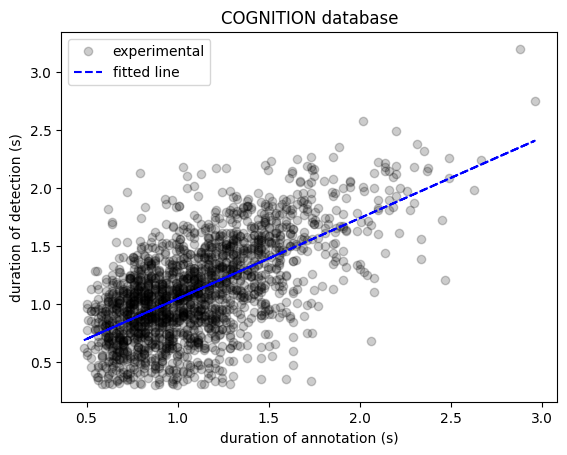

In [22]:
plt.plot(allTablesOut[allTablesOut.tp].durationGT,allTablesOut[allTablesOut.tp].durationOut,linestyle='',marker='o',color='black',alpha=0.2,label='experimental')
plt.plot(allTablesOut[allTablesOut.tp].durationGT, result.intercept + result.slope*np.array(allTablesOut[allTablesOut.tp].durationGT), 'b', label='fitted line',linestyle='--')
plt.legend()
plt.xlabel("duration of annotation (s)")
plt.ylabel("duration of detection (s)")
plt.title("COGNITION database")
plt.show()

### Correlation of number of detections

In [23]:
detectionNumber=list(map(lambda x: len(x),allDetections))
annotationNumber=list(map(lambda x: len(x),allAnnotations))

In [24]:
res=sst.linregress(annotationNumber,detectionNumber)
res

LinregressResult(slope=1.020925486415746, intercept=42.333567719931864, rvalue=0.8672723586345537, pvalue=0.0114619118338498, stderr=0.262082523143836, intercept_stderr=110.54997293877327)

In [25]:
res.pvalue

0.0114619118338498

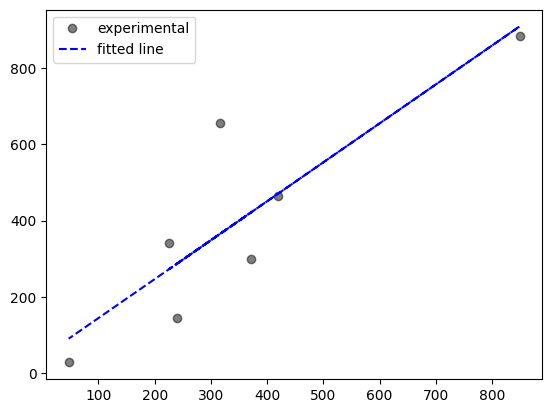

In [26]:
plt.plot(annotationNumber,detectionNumber,linestyle='',marker='o',color='black',alpha=0.5,label='experimental')
plt.plot(annotationNumber, res.intercept + res.slope*np.array(annotationNumber), 'b', linestyle='--', label='fitted line')
plt.legend()
plt.show()


### Correlations of density of spindles

In [27]:
signalsMetadata.head()

,filename,channel,subjectId,duration,samplerate,isOriginalSamplerate,database
0,COG001_canal_C3.txt,C3-M2,0001,39600,200,False,COGNITION
1,COG002_canal_C3.txt,C3-M2,0002,39600,200,False,COGNITION
2,COG003_canal_C3.txt,C3-M2,0003,39600,200,False,COGNITION
3,COG004_canal_C3.txt,C3-M2,0004,39600,200,False,COGNITION
4,COG005_canal_C3.txt,C3-M2,0005,39600,200,False,COGNITION


In [28]:
durations=signalsMetadata.duration

In [29]:
detectionDensity=list(map(lambda x: len(x[0])/(x[1]/3600),zip(allDetections,durations)))
annotationDensity=list(map(lambda x: len(x[0])/(x[1]/3600),zip(allAnnotations,durations)))

In [30]:
res=sst.linregress(annotationDensity,detectionDensity)
print(res)

LinregressResult(slope=1.0209254864157458, intercept=3.848506156357452, rvalue=0.8672723586345537, pvalue=0.0114619118338498, stderr=0.2620825231438359, intercept_stderr=10.049997539888473)


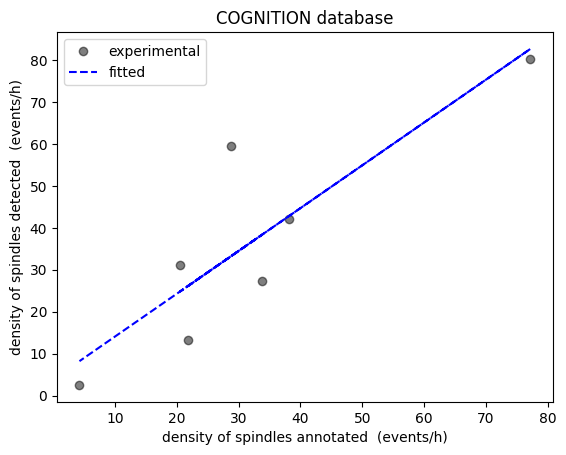

In [31]:
plt.plot(annotationDensity,detectionDensity,linestyle='',marker='o',color='black',alpha=0.5,label='experimental')
plt.plot(annotationDensity, res.intercept + res.slope*np.array(annotationDensity), 'b', linestyle='--', label='fitted')
plt.legend()
plt.xlabel("density of spindles annotated  (events/h)")
plt.ylabel("density of spindles detected  (events/h)")
plt.title("COGNITION database")
plt.show()